# Bidirectional LSTM for Time Series forecasting

In [64]:
from utilities.std_imports import *
import time
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as tk

In [11]:
ds = pd.read_csv("D:/data/csv/temp_Melbourne.csv")
ds['Temp'] = ds['Temp'].apply(lambda x: float(x)) #convert to float
print(ds.info())
ds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB
None


,Date,Temp
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [10]:
ts = data['Temp']

scaler = MinMaxScaler(feature_range=(-1,1))
X =scaler.fit_transform(ts.values.reshape(-1,1))

X_train = X[:-100]
y = X[-100:]
X_train.shape, y.shape

((3550, 1), (100, 1))

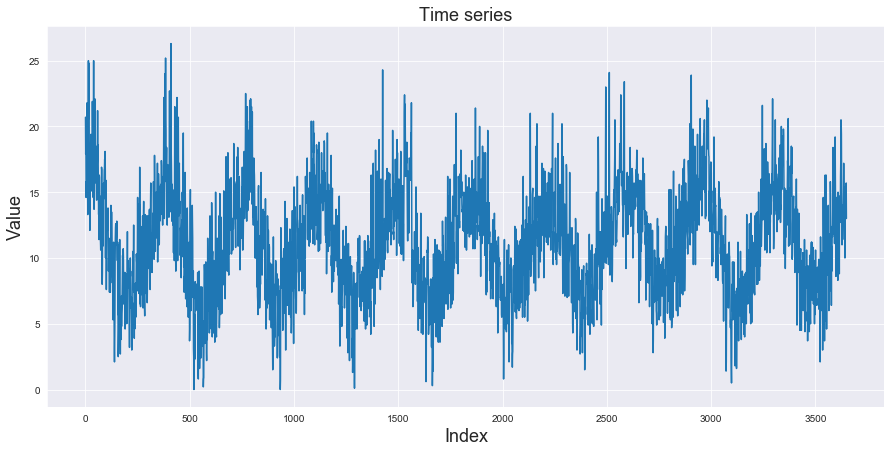

In [13]:
plt.figure(figsize=(15,7))
plt.title("Time series", fontsize = 18)
plt.xlabel("Index", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.plot(ts)
plt.show()

## Generate Training dataset

In [46]:
ts_in_len = 60
ts_out_len = 20
n_in_features = 1
n_out_features = 1
batch_size = 10

In [55]:
def gen_trainingDf(x):
    
    total_start_points = len(x) - ts_in_len - ts_out_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i + ts_in_len)) for i in start_x_idx]
    input_ts = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i + ts_in_len, i + ts_in_len + ts_out_len)) for i in start_x_idx]
    output_ts = np.take(x, output_batch_idxs, axis = 0)
    
    input_ts = (input_ts.reshape(input_ts.shape[0],input_ts.shape[1],n_in_features))
    output_ts = (output_ts.reshape(output_ts.shape[0],output_ts.shape[1],n_out_features))
    
    return input_ts, output_ts

## Build model

In [79]:
def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    # Encoder
    encoder_inputs = tk.layers.Input(shape=(None, n_in_features))
    lstm_cells = [tk.layers.LSTMCell(hidden_dim) for hidden_dim in layers]
    
    if bidirectional:
        encoder = tk.layers.Bidirectional(tk.layers.RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = tk.layers.concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = tk.layers.RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    # Decoder
    decoder_inputs = tk.layers.Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [tk.layers.LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [tk.layers.LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = tk.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = tk.layers.Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = tk.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

## Train

In [57]:
def train(model,batches,epochs,batch_size):

    for _ in range(batches):

        input_ts, output_ts = gen_trainingDf(X_train)

        encoder_input_data = input_ts
        decoder_target_data = output_ts
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_split=0.1, shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

## Unidirectional 1-Layered

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
rnn_29 (RNN)                    [(None, 60), [(None, 14880       input_30[0][0]                   
__________________________________________________________________________________________________
rnn_30 (RNN)                    [(None, None, 60), [ 14880       input_31[0][0]                   
                                                                 rnn_29[0][1]              

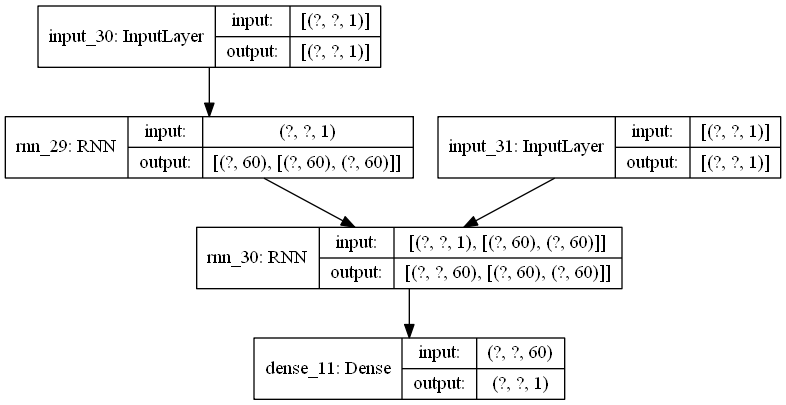

In [80]:
model1 = create_model(layers=[60],bidirectional=False)

model1.summary()
tk.utils.plot_model(model1, show_shapes=True, show_layer_names=True)

In [59]:
total_loss = []
total_test_loss = []
model_1.compile(tk.optimizers.Adam(), loss = 'mean_squared_error')
train(model_1, batches=1, epochs=100, batch_size=batch_size)

Epoch 1/100
313/313 [==============================] - 10s 31ms/step - loss: 0.0546 - val_loss: 0.0501
Epoch 2/100
313/313 [==============================] - 9s 29ms/step - loss: 0.0488 - val_loss: 0.0495
Epoch 3/100
313/313 [==============================] - 9s 29ms/step - loss: 0.0476 - val_loss: 0.0495
Epoch 4/100
313/313 [==============================] - 9s 28ms/step - loss: 0.0471 - val_loss: 0.0464
Epoch 5/100
313/313 [==============================] - 9s 29ms/step - loss: 0.0467 - val_loss: 0.0459
Epoch 6/100
313/313 [==============================] - 9s 29ms/step - loss: 0.0464 - val_loss: 0.0451
Epoch 7/100
313/313 [==============================] - 9s 28ms/step - loss: 0.0463 - val_loss: 0.0448
Epoch 8/100
313/313 [==============================] - 9s 28ms/step - loss: 0.0460 - val_loss: 0.0448
Epoch 9/100
313/313 [==============================] - 8s 27ms/step - loss: 0.0459 - val_loss: 0.0448
Epoch 10/100
313/313 [==============================] - 8s 27ms/step - loss: 0.04

In [66]:
def plot_loss(train_loss,test_loss):   
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(test_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

plot_loss(total_loss, total_test_loss)

NameError: name 'total_test_loss' is not defined

### Predict

In [67]:
input_ts_test = X_train[-60:].reshape((1,60,1))
output_ts_test = y[:20]
decoder_input_test = np.zeros((1,output_ts_len,1))

pred1 = model_1.predict([input_ts_test,decoder_input_test])

pred_values1 = scaler.inverse_transform(pred1.reshape(-1,1))
output_ts_test1 = scaler.inverse_transform(output_ts_test)

NameError: name 'output_ts_len' is not defined

In [ ]:
plt.plot(pred_values1, label = "pred")
plt.plot(output_ts_test1, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Temperature", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('uni_dir1.png')

## Bi-directional 1-layered

In [81]:
model1_bi = create_model(layers=[60], bidirectional=True)

#total_loss = []
#total_val_loss = []
#model1_bi.compile(tk.optimizers.Adam(), loss = 'mean_squared_error')

#train(model1_bi,batches=1, epochs=100, batch_size=batch_size)

#total_loss = [j for i in total_loss for j in i]
#total_val_loss = [j for i in total_val_loss for j in i]

#plot_loss(total_loss,total_val_loss)

IndexError: list index out of range

In [102]:
    layers = [60]
    bidirectional = True
    
    n_layers = len(layers)

    # Encoder
    encoder_inputs = tk.layers.Input(shape=(None, n_in_features))
    lstm_cells = [tk.layers.LSTMCell(hidden_dim) for hidden_dim in layers]

1


In [103]:
encoder = tk.layers.Bidirectional(tk.layers.RNN(lstm_cells, return_state=True))
encoder_outputs_and_states = encoder(encoder_inputs)
bi_encoder_states = encoder_outputs_and_states[1:]
#print(int(len(bi_encoder_states)/2))
encoder_states = []
#for i in range(int(len(bi_encoder_states)/2)):
i=0
print(n_layers)
temp = tk.layers.concatenate([bi_encoder_states[i], bi_encoder_states[2*n_layers + i]], axis=-1)
#encoder_states.append(temp)


60


IndexError: list index out of range

In [ ]:
   
    # Decoder
    decoder_inputs = tk.layers.Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [tk.layers.LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [tk.layers.LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = tk.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = tk.layers.Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = tk.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [69]:
input_ts_test = X_train[-60:].reshape((1,60,1))
output_ts_test = y[:20]
decoder_input_test = np.zeros((1,ts_out_len,1))

pred = model1_bi.predict([input_ts_test,decoder_input_test])

pred_values = scaler.inverse_transform(pred.reshape(-1,1))
output_ts_test = scaler.inverse_transform(output_ts_test)
input_ts_test = scaler.inverse_transform(input_ts_test.reshape(-1,1))

plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Temperature", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend()
plt.savefig('bi_dir1.png')

NameError: name 'model1_bi' is not defined

## Credits & Links

https://github.com/manohar029/TimeSeries-Seq2Seq-deepLSTMs-Keras/blob/master/Keras_Enc-Dec_MinTempMel.ipynb
https://towardsdatascience.com/time-series-forecasting-with-deep-stacked-unidirectional-and-bidirectional-lstms-de7c099bd918